In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download grassknoted/asl-alphabet

 99% 1.01G/1.03G [00:09<00:00, 151MB/s]
100% 1.03G/1.03G [00:09<00:00, 114MB/s]


In [ ]:
import shutil
shutil.unpack_archive('/content/asl-alphabet.zip', '/content/')

In [ ]:
train_dir = '/content/asl_alphabet_train/asl_alphabet_train/'
test_dir = '/content/asl_alphabet_test/asl_alphabet_test/'

In [ ]:
from glob import glob
import os
classes = glob(os.path.join(train_dir, '*'))
banyakClass = len(classes)
IMAGE_SIZE = [224, 224, 3]

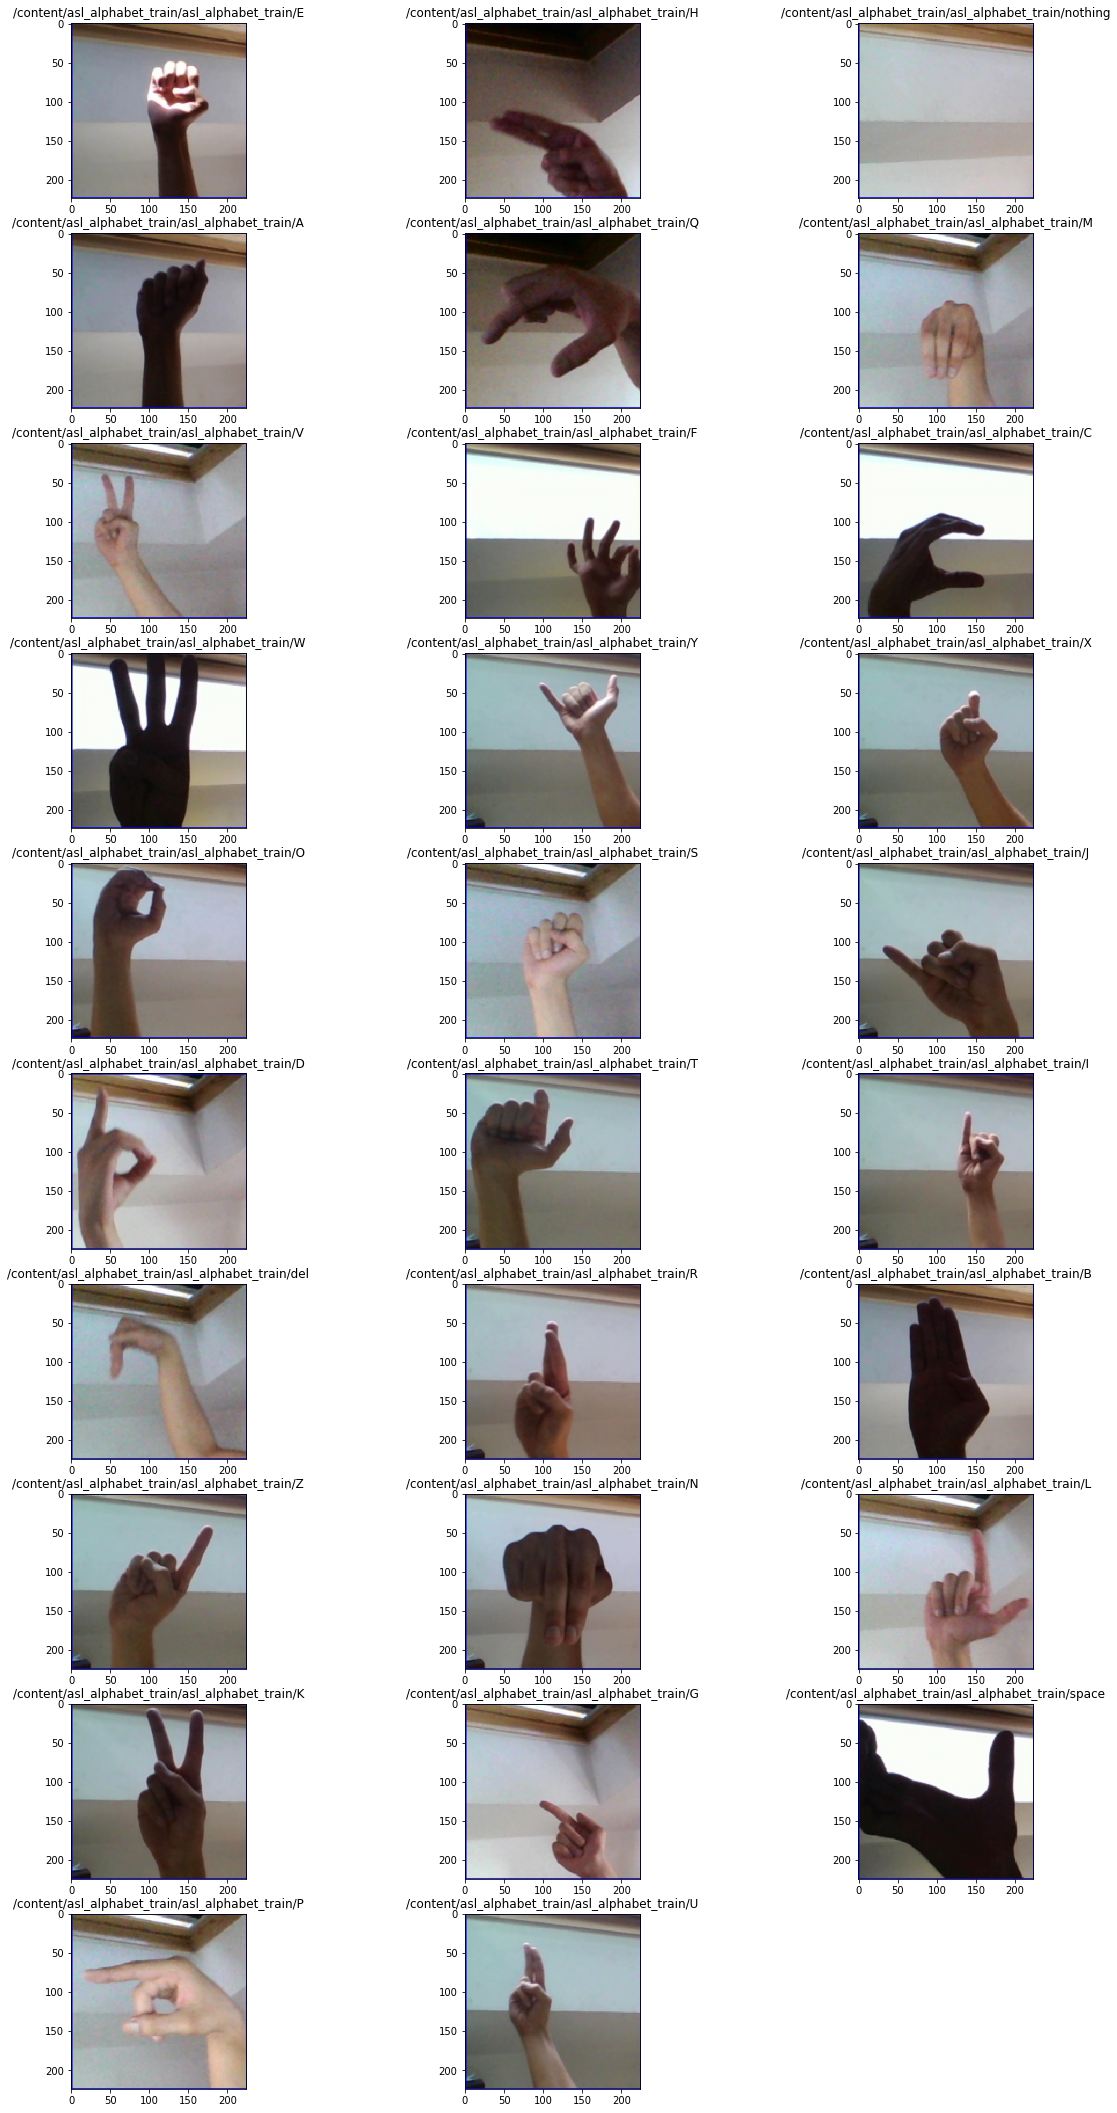

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
plt.figure(figsize=(20,38))
for i in enumerate(classes):
    img = image.load_img(str(i[1])+'/'+os.listdir(i[1])[0], target_size=IMAGE_SIZE)
    plt.subplot(10,3,i[0]+1)
    plt.imshow(img)
    plt.title('{0}'.format(i[1]))
plt.show()

In [ ]:
for i in classes:
  print(i, 'sebanyak', len(os.listdir(i)))

/content/asl_alphabet_train/asl_alphabet_train/E sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/H sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/nothing sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/A sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/Q sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/M sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/V sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/F sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/C sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/W sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/Y sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/X sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/O sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/S sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/J sebanyak 3000
/content/asl_alphabet_train/asl_alphabet_train/D 

# Augmentation

In [ ]:
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range = 0.2,
    validation_split=0.2,
    horizontal_flip = True,
    brightness_range=(0.75, 1.3),
    zoom_range=0.2
)

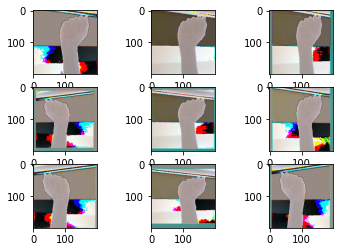

In [ ]:
from numpy import expand_dims
from matplotlib import pyplot

img = image.load_img('/content/asl_alphabet_test/asl_alphabet_test/A_test.jpg')
data = image.img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)
for i in range(9):
	pyplot.subplot(330 + 1 + i)
	batch = it.next()
	image = batch[0].astype('uint8')
	pyplot.imshow(image)
pyplot.show()

In [ ]:
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='training'
)
validation_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    shuffle=True,
    subset='validation'
)

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


# Impor Pre Trained Model Resnet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE, pooling='avg')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
for layer in model.layers[:(len(model.layers))]:
    layer.trainable = True

for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 conv1_bn True
4 conv1_relu True
5 pool1_pad True
6 pool1_pool True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_conv True
11 conv2_block1_2_bn True
12 conv2_block1_2_relu True
13 conv2_block1_0_conv True
14 conv2_block1_3_conv True
15 conv2_block1_0_bn True
16 conv2_block1_3_bn True
17 conv2_block1_add True
18 conv2_block1_out True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_conv True
23 conv2_block2_2_bn True
24 conv2_block2_2_relu True
25 conv2_block2_3_conv True
26 conv2_block2_3_bn True
27 conv2_block2_add True
28 conv2_block2_out True
29 conv2_block3_1_conv True
30 conv2_block3_1_bn True
31 conv2_block3_1_relu True
32 conv2_block3_2_conv True
33 conv2_block3_2_bn True
34 conv2_block3_2_relu True
35 conv2_block3_3_conv True
36 conv2_block3_3_bn True
37 conv2_block3_add True
38 conv2_block3_out True
39 conv3_block1_1_conv Tru

In [ ]:
from keras.layers import Input, Lambda, Dense, Flatten, Dropout
from keras.regularizers import l1_l2
from keras.layers import BatchNormalization

x = Flatten()(model.output)
x = BatchNormalization()(x)
x = Dense(1000, activation='relu')(x)
x = (Dropout(0.25))(x)
pred = Dense(banyakClass, activation='softmax')(x)

In [ ]:
from keras.models import Model
model = Model(inputs=model.input, outputs=pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from tensorflow import keras

opt = keras.optimizers.Adam(learning_rate=0.00001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

# Training

In [ ]:
gdrivePath = '/content/drive/MyDrive/Resnet50/'

In [ ]:
import keras
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
batch_size = 64
epochs = 2
checkpoint = ModelCheckpoint(gdrivePath+'ep{epoch:03d}-loss{loss:.2f}-val_loss{val_loss:.2f}-acc{acc:.2f}-vacc{val_acc:.2f}.h5',
        monitor='val_loss', save_weights_only=True, save_best_only=True, period=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

history = model.fit(
    training_set,
    steps_per_epoch = training_set.samples // batch_size,
    validation_data = validation_set, 
    validation_steps = validation_set.samples // batch_size,
    epochs = epochs,
    callbacks=[checkpoint, reduce_lr, es_callback])

Epoch 1/2
1087/1087 [==============================] - 1838s 2s/step - loss: 0.5864 - acc: 0.8551 - val_loss: 0.1570 - val_acc: 0.9509 - lr: 1.0000e-05
Epoch 2/2
1087/1087 [==============================] - 1791s 2s/step - loss: 0.0151 - acc: 0.9975 - val_loss: 0.1114 - val_acc: 0.9643 - lr: 1.0000e-05


# Inference

In [ ]:
weightName = 'ep002-loss0.02-val_loss0.11-acc1.00-vacc0.96.h5'

In [ ]:
# load model
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.models import Model
from tensorflow import keras

model = ResNet50(weights='imagenet', include_top=False, input_shape=IMAGE_SIZE, pooling='avg')
x = Flatten()(model.output)
x = BatchNormalization()(x)
x = Dense(1000, activation='relu')(x)
x = (Dropout(0.25))(x)
pred = Dense(banyakClass, activation='softmax')(x)
model = Model(inputs=model.input, outputs=pred)
opt = keras.optimizers.Adam(learning_rate=0.00001)
model.load_weights(gdrivePath+weightName)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

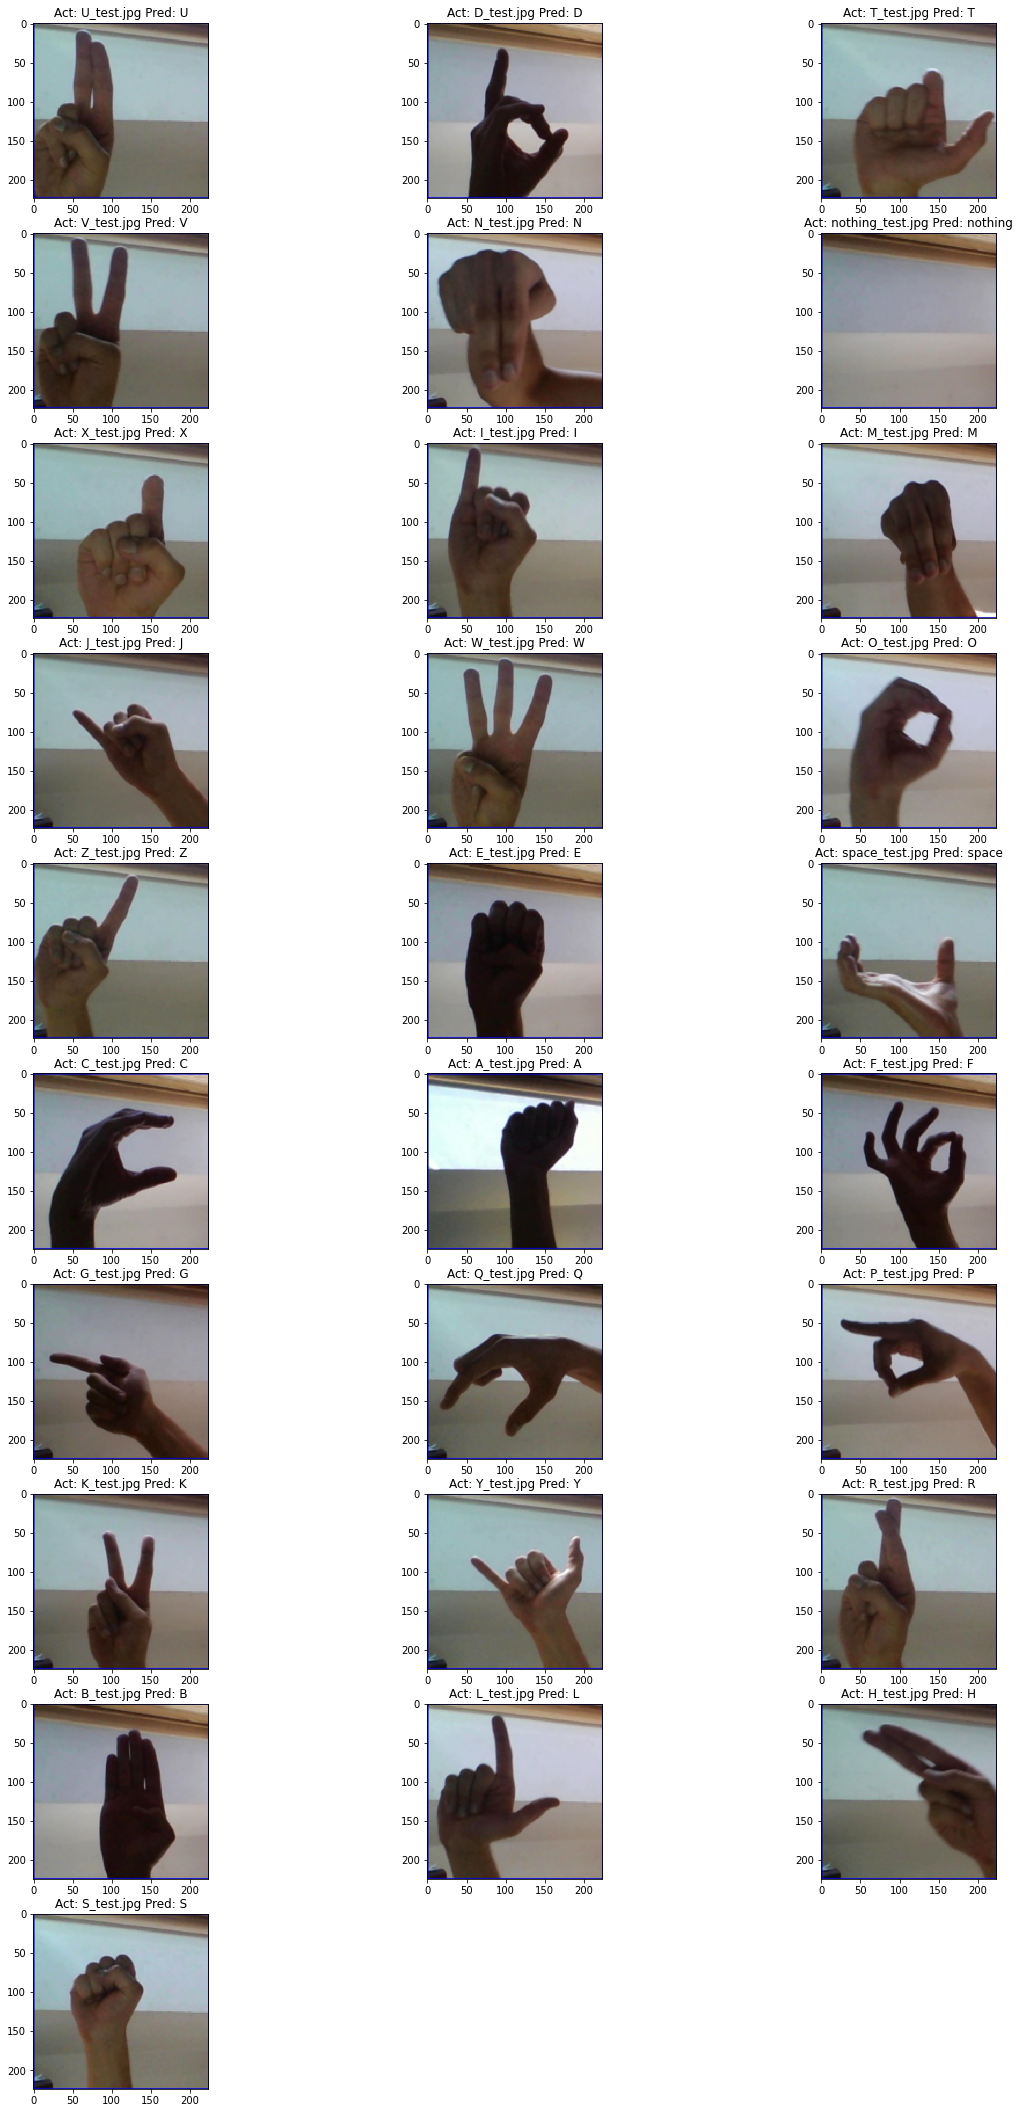

In [ ]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

kelas = list(training_set.class_indices)
plt.figure(figsize=(20,38))
for i in enumerate(os.listdir(test_dir)):
    img = image.load_img(test_dir+i[1], target_size=IMAGE_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    images = preprocess_input(x)
    classProb = model.predict(images, batch_size=10)
    plt.subplot(10,3,i[0]+1)
    plt.imshow(img)
    plt.title('Act: {0} Pred: {1}'.format(i[1], kelas[np.argmax(classProb)]))
plt.show()